### Aplicando análisis de componentes principales

Una vez hemos limpiado el dataset de imagenes, deseamos conocer hasta qué punto podríamos reducir la dimensionalidad de las mismas preservando en ellas las secciones más importantes, es decir, que se puedan seguir identificando la distribución de la dentadura, problemas de caries, entre otras afecciones dentales

Dependiendo de los resultados de este análisis podríamos:
- Contar un cojunto de imagenes de menor peso y tamaño lo que nos permitirá probar modelos de clusterización complejos.
- Reducir el "ruido" en las imagenes.  El ruido bajo el escenario de nuestro proyecto está representado por aquellos pixeles que se encuentran alrededor de los labios, las mejillas y alrededor de la mandibula, por lo que esperamos una gran reducción de dimensionalidad aplicando esta técnica.
- Poder visualizarlas de manera eficiente en caso de requerirse.

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pca import pca
from PIL import Image
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# !pip install tables

Cargamos en un dataframe las imagenes y sus propiedades tras el proceso de limpieza y transformación realizado previamente en 2_Clean_dataset.ipynb.

In [2]:
df = pd.read_hdf('2_Cleaned_dataset/images.h5', key='data')
df.shape

(910, 10)

In [3]:
df.head()

,full_path,main_folder,intermediate_path,file_name,format,height,width,size,bands,image
0,2_Cleaned_dataset\images\1.png,images,images,1.png,PNG,188,398,38377,1,"[[207, 196, 188, 185, 192, 199, 216, 233, 239,..."
1,2_Cleaned_dataset\images\10.png,images,images,10.png,PNG,188,398,36997,1,"[[197, 209, 205, 191, 174, 158, 146, 150, 158,..."
2,2_Cleaned_dataset\images\100.png,images,images,100.png,PNG,188,398,37350,1,"[[164, 158, 141, 148, 157, 154, 172, 183, 186,..."
3,2_Cleaned_dataset\images\100_2812.png,images,images,100_2812.png,PNG,188,398,37226,1,"[[209, 214, 215, 217, 217, 216, 217, 219, 219,..."
4,2_Cleaned_dataset\images\101.png,images,images,101.png,PNG,188,398,36627,1,"[[150, 138, 138, 136, 125, 128, 128, 131, 121,..."


Obtenemos una muestra del dataframe y visualizamos algunas de las imágenes disponibles

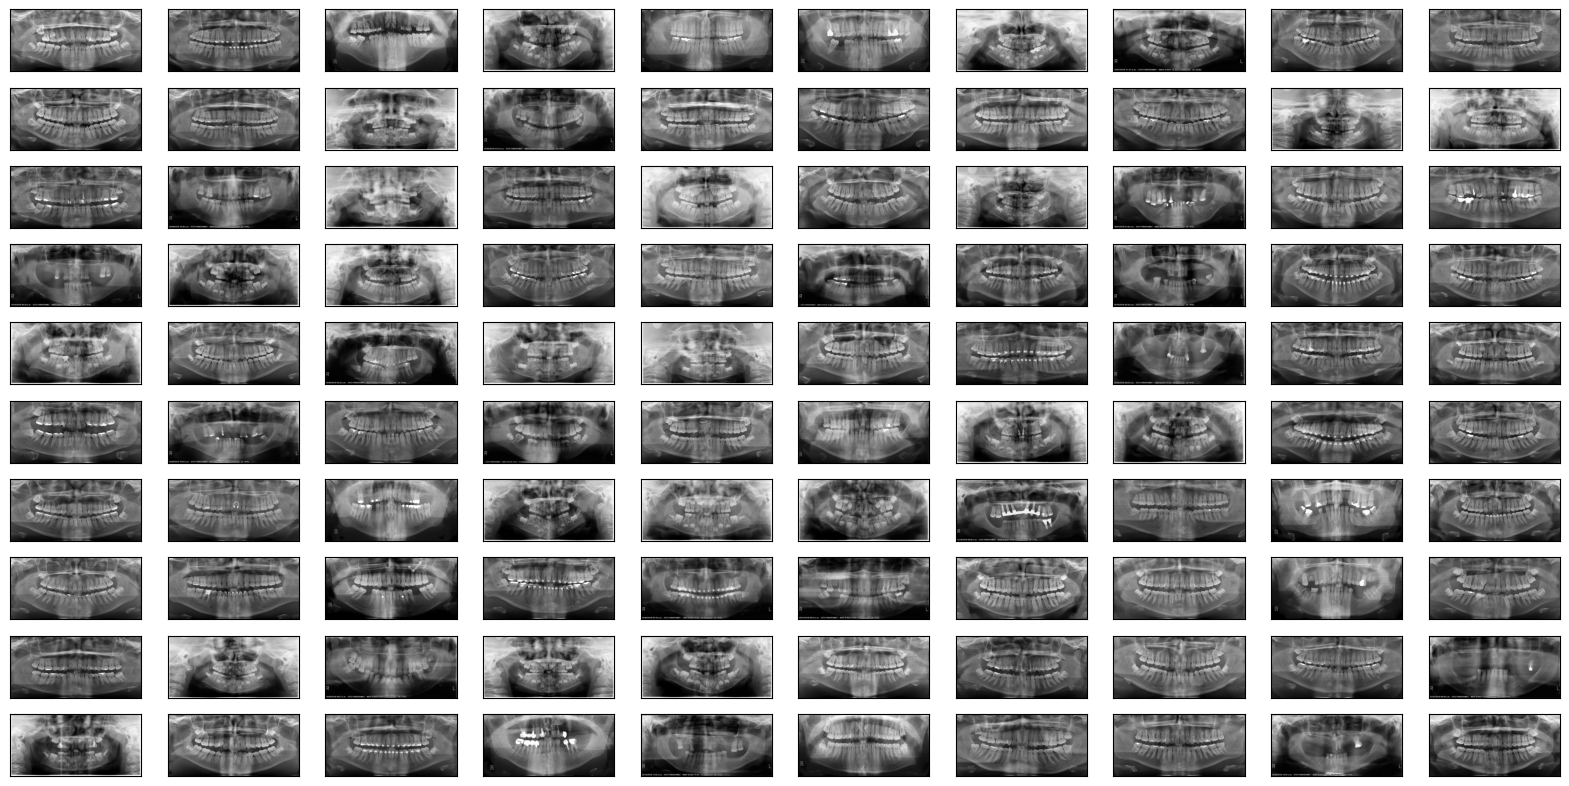

In [4]:
# Obtenemos una muestra del dataframe para trabajar un poco más rápido
df_sample = df.sample(n=100)

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow((df_sample[i:i+1]['image'].values[0]), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [5]:
# Aplanamos las imágenes antes de crear una matriz de valores estandarizados
X = np.stack(df['image'].apply(lambda x: x.flatten()))
X.shape

(910, 74824)

In [6]:
# Estandarizamos los datos
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Crea un DataFrame a partir de los datos escalados
X_standardized_df = pd.DataFrame(X_standardized)
X_standardized_df

,0,1,2,3,4,5,6,7,8,9,...,74814,74815,74816,74817,74818,74819,74820,74821,74822,74823
0,0.343527,0.118632,-0.030663,-0.081757,0.080161,0.249434,0.631962,0.988661,1.118684,1.325216,...,-0.841336,-0.844258,-0.847812,-0.854670,-0.862017,-0.873673,-0.891742,-0.918227,-0.953645,-1.017619
1,0.132661,0.390085,0.323863,0.042899,-0.293390,-0.608614,-0.836055,-0.731730,-0.552981,-0.684419,...,-0.680057,-0.672505,-0.687132,-0.683567,-0.680068,-0.680488,-0.697646,-0.722692,-0.745391,-0.807518
2,-0.563199,-0.674846,-1.010824,-0.850467,-0.646189,-0.692326,-0.290792,-0.047719,0.024879,-0.021446,...,-0.830584,-0.833524,-0.815676,-0.801200,-0.797800,-0.787813,-0.816260,-0.907364,-0.898841,-0.752229
3,0.385701,0.494489,0.532408,0.583074,0.598982,0.605210,0.652933,0.698475,0.705927,0.682962,...,-0.615545,-0.608097,-0.612148,-0.619403,-0.594445,-0.551698,-0.481983,-0.266444,-0.043903,0.309330
4,-0.858413,-1.092466,-1.073388,-1.099779,-1.310280,-1.236454,-1.213545,-1.125554,-1.316580,-1.347391,...,-0.841336,-0.844258,-0.847812,-0.854670,-0.862017,-0.873673,-0.891742,-0.918227,-0.953645,-1.017619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,1.355687,1.329729,1.283170,1.268680,1.221567,1.191194,1.198197,1.195937,1.180597,1.200909,...,1.846658,1.860860,1.862318,1.861594,1.856514,1.863115,1.857959,1.851854,1.841345,1.802146
906,1.355687,1.350610,1.345734,1.331008,1.325331,1.337690,1.344998,1.341030,1.325062,1.366652,...,1.846658,1.850125,1.851606,1.861594,1.856514,1.852382,1.857959,1.851854,1.841345,1.802146
907,1.355687,1.350610,1.345734,1.310232,1.304578,1.337690,1.344998,1.341030,1.304424,1.345934,...,1.868162,1.860860,1.851606,1.861594,1.867217,1.863115,1.847176,1.851854,1.841345,1.802146
908,1.355687,1.350610,1.345734,1.331008,1.325331,1.337690,1.324027,1.299575,1.304424,1.304498,...,1.878914,1.871594,1.873030,1.872288,1.867217,1.863115,1.857959,1.851854,1.841345,1.802146


Ahora identificaremos qué tanto podríamos reducir la dimension de las imágenes de manera que aún pueda explicarse entre el 90% y 95% de la varianza.   Nos apoyaremos en el módulo pca de la librería con el mismo nombre.  Como nuestras imagenes están representadas por 74824 columnas o posiciones,  dejamos que el algoritmo de pca encuentre el número de componentes principales por nosotros.  Al no especificar el número de componentes que deseamos el algoritmo por defecto resaltará aquella cantidad de componentes principales que explican el 95% de la varianza.

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [74824] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [348] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [74824] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[348]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


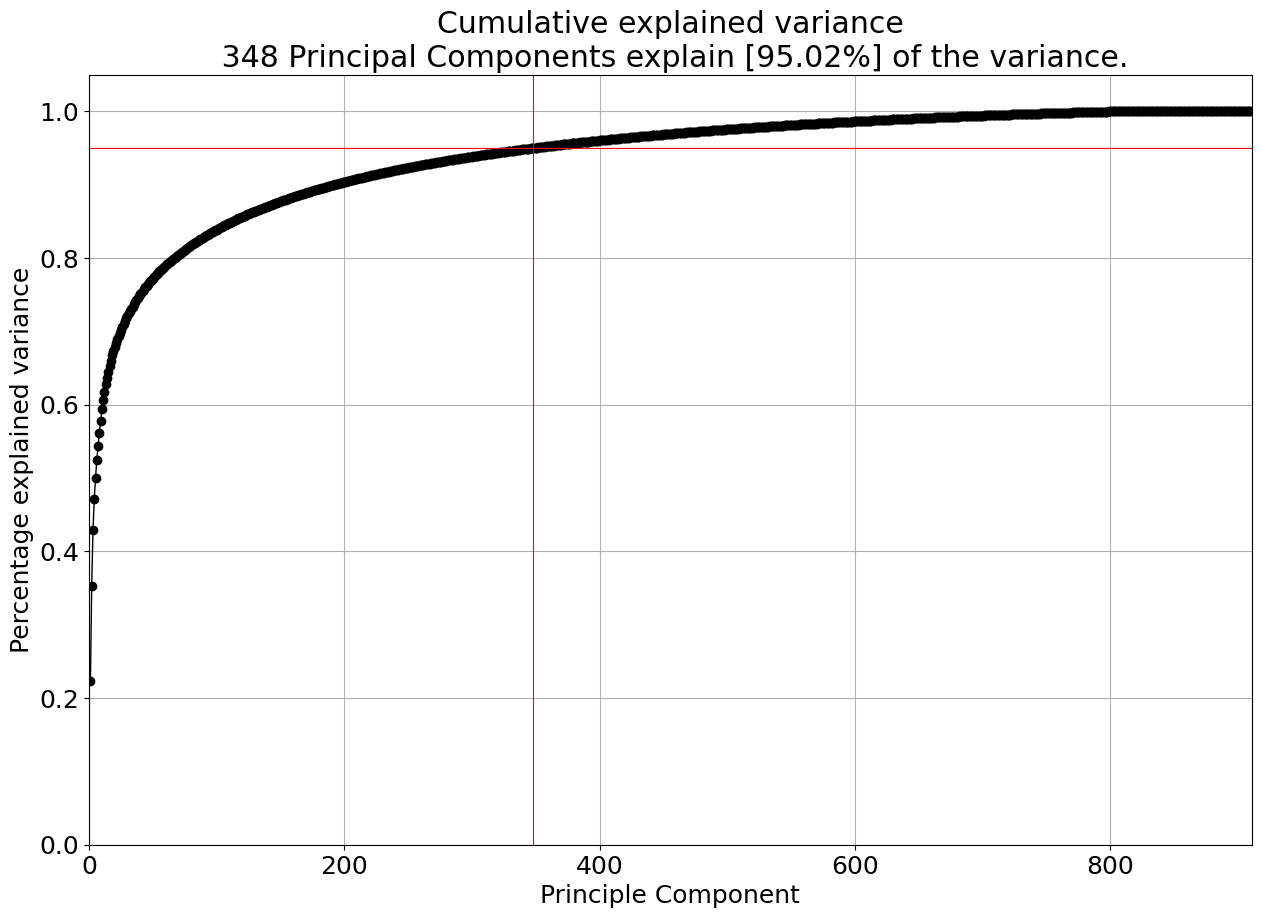

In [25]:
model = pca()
model.fit_transform(X_standardized_df)
fig, ax = model.plot()

Encontramos entonces que 348 componentes explican el 95.02% de la varianza de las imagenes.

In [ ]:
# Para hacer algo similar con SVD se requiere mucha mas RAM
# Intenté probar en Colab pero no pude abrir el archivo H5
# U, S, VT = np.linalg.svd(X_standardized_df)

In [72]:
pca = PCA(n_components=348)
X_reduced = pca.fit_transform(X)
X_reduced

array([[-3398.74518258, -3369.58476569,  7257.43664724, ...,
          -31.53233164,   301.44817986,  -218.62493022],
       [-3666.66697721, -4299.00277904,  5490.97152772, ...,
          343.21735979,   110.15640993,   -65.55249784],
       [-4296.58289182, -2240.4741632 ,  7128.35584783, ...,
         -115.38652648,   164.59987202,  -104.58086023],
       ...,
       [ 9889.80037671,  -180.31290326, -1073.97093569, ...,
          183.55646274,   148.90723753,   -43.78334513],
       [10510.87773754,  5163.09787066,  -801.42427865, ...,
         -113.51560305,  -118.57291153,   -40.3424849 ],
       [10510.06035546,  3867.22739543,  -373.21114347, ...,
          118.55636803,   -31.29874521,    26.93438301]])

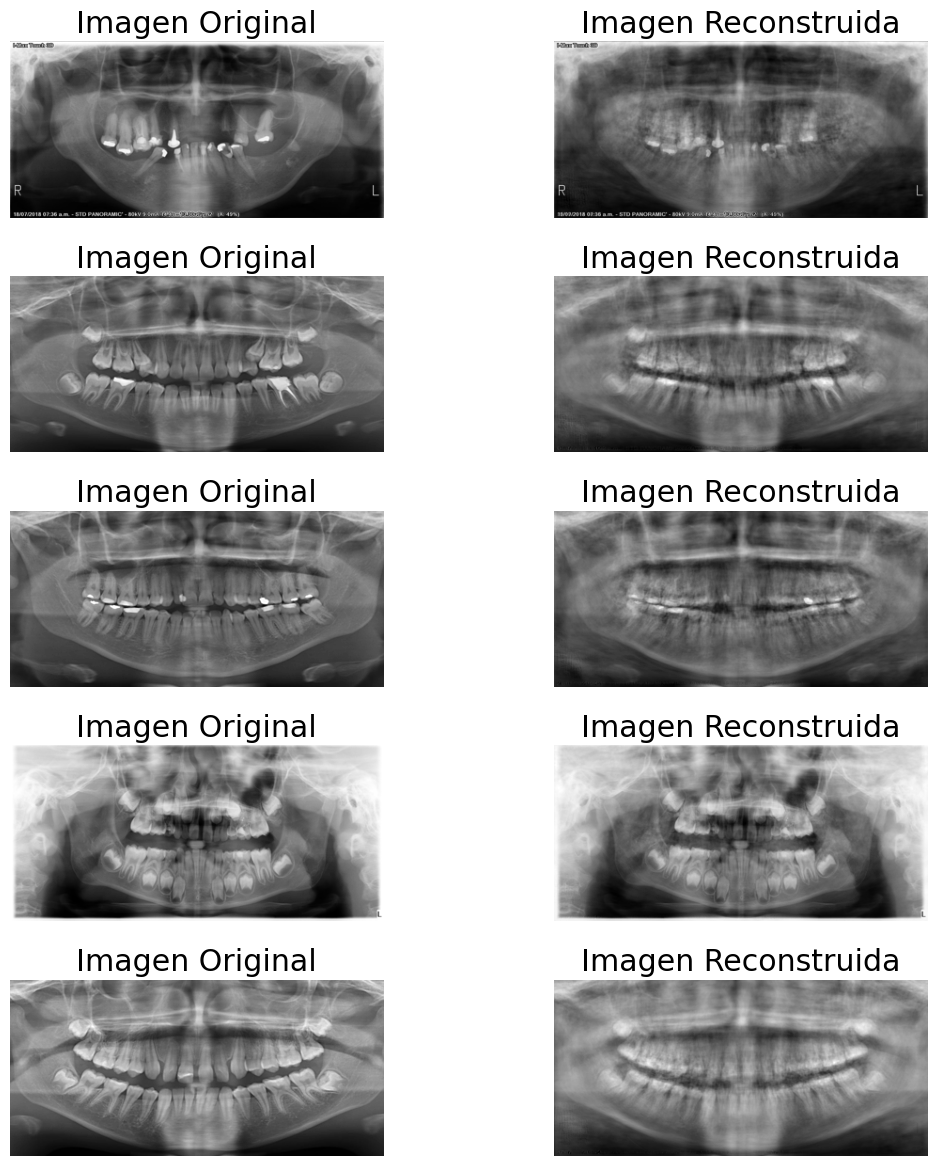

In [73]:
def plot_samples(df, reduced):
    # Número de pares de imágenes a mostrar
    num_pairs = 5
    random_indices = np.random.randint(0, len(X), size=num_pairs)

    # Crear una figura con subtramas para los pares de imágenes
    plt.figure(figsize=(12, 12))

    for i, random_index in enumerate(random_indices):
        # Obtener una imagen al azar y su correspondiente reducida
        sample = df.iloc[random_index]['image']
        sample_reduced = reduced[random_index]

        sample_original = pca.inverse_transform([sample_reduced])
        sample_original = sample_original[0]

        # Subtrama para la imagen original
        plt.subplot(num_pairs, 2, 2 * i + 1)
        plt.imshow(sample.reshape((188, 398)), cmap='gray')
        plt.title('Imagen Original')
        plt.axis('off')

        # Subtrama para la imagen reconstruida
        plt.subplot(num_pairs, 2, 2 * i + 2)
        plt.imshow(sample_original.reshape((188, 398)), cmap='gray')
        plt.title('Imagen Reconstruida')
        plt.axis('off')

    # Ajustar el espaciado entre las subtramas
    plt.tight_layout()
    plt.show()

plot_samples(df, X_reduced)

Vemos que se pierde muchos detalles, volvamos a evaluar la varianza explicada, sabemos que por encima de 300 componentes se explica el 90% de la varianza. podemos revisar valores superiores a los 350 componentes.  Segun la grafica de la variazan explicada anterior un valor óptimo puede ser 700.

In [55]:
def get_explained_variance_ratio(n):
    model = PCA(n)
    model.fit_transform(X_standardized_df)
    explained_variance_ratio = model.explained_variance_ratio_
    total_explained_variance = sum(explained_variance_ratio)
    print(f"Porcentaje de varianza explicada para {n} componentes: {total_explained_variance}")

[get_explained_variance_ratio(i) for i in [350, 400, 500, 600, 700]]

Porcentaje de varianza explicada para 350 componentes: 0.9496828792187108
Porcentaje de varianza explicada para 400 componentes: 0.9596182906544553
Porcentaje de varianza explicada para 500 componentes: 0.974909476180825
Porcentaje de varianza explicada para 600 componentes: 0.9859431881298601
Porcentaje de varianza explicada para 700 componentes: 0.9940419904385611


[None, None, None, None, None]

700 componentes explican el 99.4% de la varianza, por lo que podemos hacer un nuevo intento

In [74]:
pca = PCA(n_components=700)
X_reduced = pca.fit_transform(X)
X_reduced

array([[-3.39874518e+03, -3.36958477e+03,  7.25743665e+03, ...,
        -1.52904371e+02,  5.12079436e+01, -9.18566201e+01],
       [-3.66666698e+03, -4.29900278e+03,  5.49097153e+03, ...,
        -8.56124712e+01,  9.65467086e+00,  8.57713461e+00],
       [-4.29658289e+03, -2.24047416e+03,  7.12835585e+03, ...,
        -4.41088984e+01,  2.45982308e+01, -1.19756814e+02],
       ...,
       [ 9.88980038e+03, -1.80312903e+02, -1.07397094e+03, ...,
        -2.73626479e+00,  2.52206818e+00,  1.96419179e-01],
       [ 1.05108777e+04,  5.16309787e+03, -8.01424279e+02, ...,
         1.50676551e+01,  5.16241345e+01,  4.84060382e+01],
       [ 1.05100604e+04,  3.86722740e+03, -3.73211143e+02, ...,
        -5.64073611e+00,  2.65757696e+01, -4.31226260e+01]])

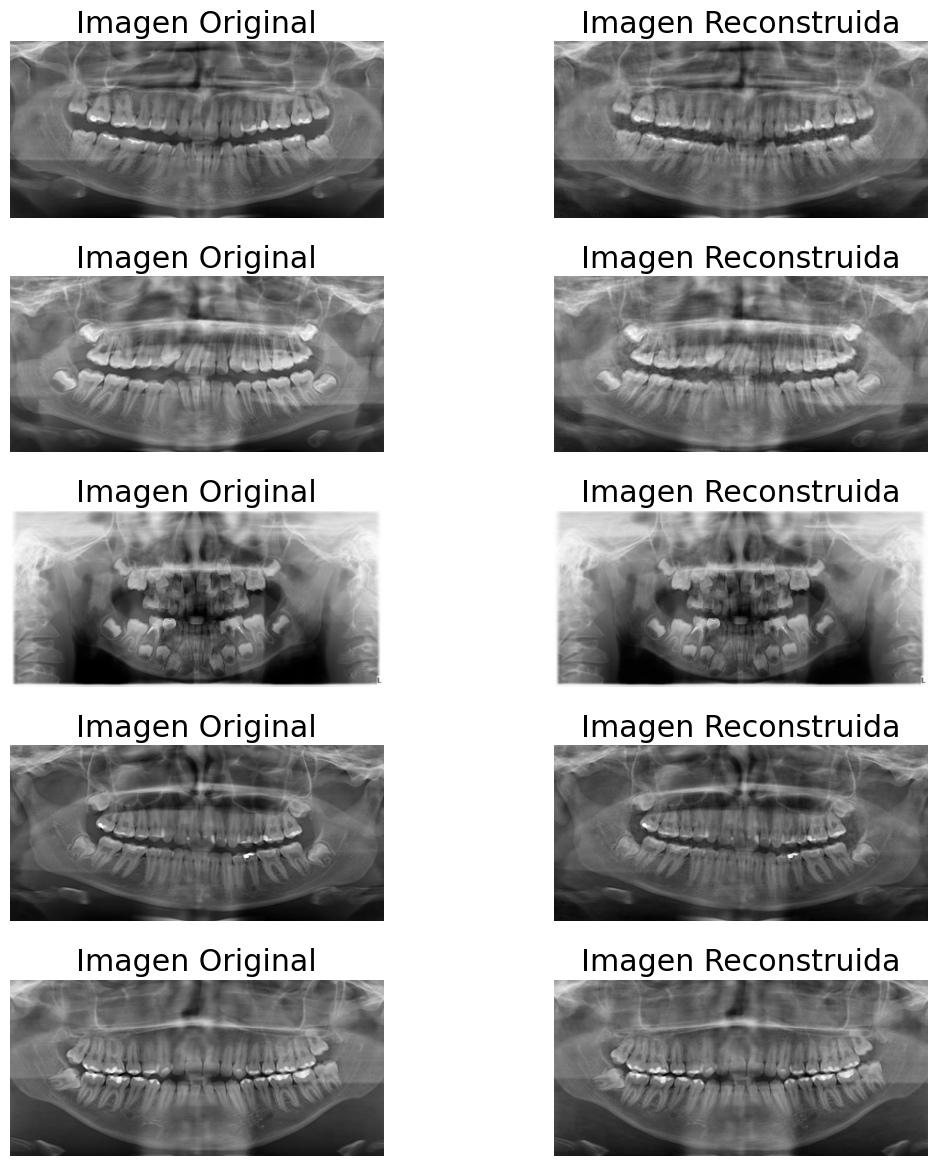

In [75]:
plot_samples(df, X_reduced)